In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [9]:
data = pd.read_excel('Daily-Fx.xlsx')
data.head()

,Date,DFX
0,31/12/1979,1.726
1,1980-02-01 00:00:00,1.714
2,1980-03-01 00:00:00,1.711
3,1980-04-01 00:00:00,1.713
4,1980-07-01 00:00:00,1.708


In [10]:
data.isnull().sum()


Date    0
DFX     0
dtype: int64

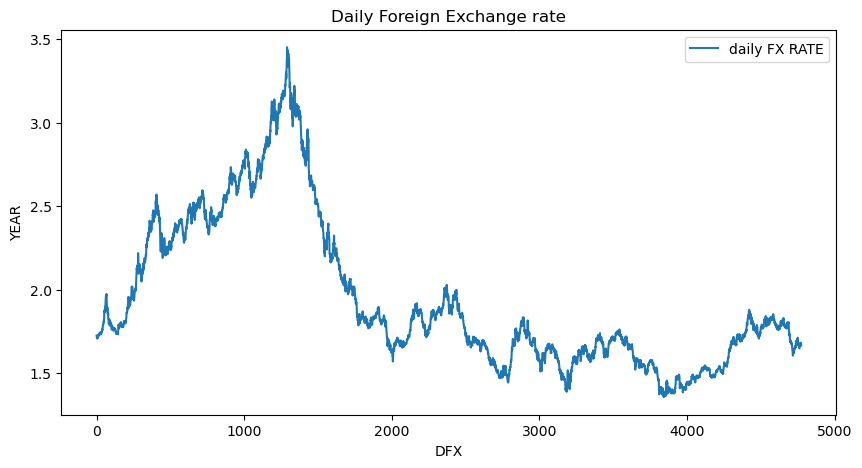

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(data['DFX'], label='daily FX RATE')
plt.title('Daily Foreign Exchange rate')
plt.xlabel('DFX')
plt.ylabel('YEAR')
plt.legend()
plt.show()

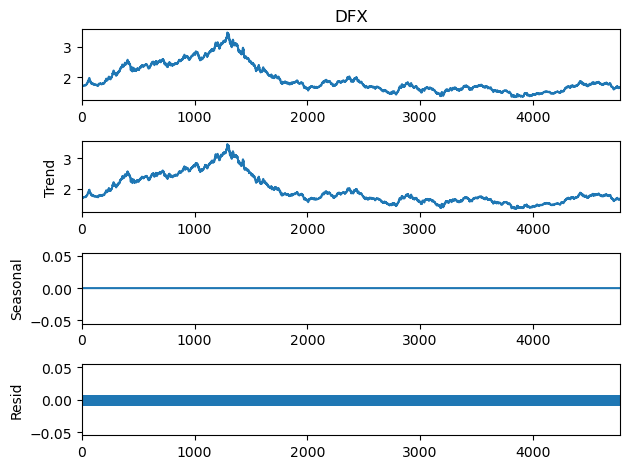

In [12]:
# Step 4: Decompose Time Series
decomposition = seasonal_decompose(data['DFX'], model='additive', period=1)
decomposition.plot()
plt.show()

In [13]:
result = adfuller(data['DFX'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -1.211436469664877
p-value: 0.6686567842160313


In [14]:
# Apply log transformation and differencing
data['Log_DFX'] = np.log(data['DFX'])
data['Log_Differenced_DFX'] = data['Log_DFX'].diff().dropna()


In [15]:
result = adfuller(data['Log_Differenced_DFX'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -66.6897484722663
p-value: 0.0


In [16]:
data = data.dropna()
data.head()

,Date,DFX,Log_DFX,Log_Differenced_DFX
1,1980-02-01 00:00:00,1.714,0.538830,-0.006977
2,1980-03-01 00:00:00,1.711,0.537078,-0.001752
3,1980-04-01 00:00:00,1.713,0.538246,0.001168
4,1980-07-01 00:00:00,1.708,0.535323,-0.002923
5,1980-08-01 00:00:00,1.713,0.538246,0.002923


In [18]:
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]


In [19]:
# Step 7: Model Selection (ARIMA Model)
model = ARIMA(train['Log_Differenced_DFX'], order=(5, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\hunsu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hunsu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hunsu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hunsu\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                SARIMAX Results                                
Dep. Variable:     Log_Differenced_DFX   No. Observations:                 3818
Model:                  ARIMA(5, 1, 0)   Log Likelihood               13186.513
Date:                 Fri, 31 May 2024   AIC                         -26361.026
Time:                         21:03:16   BIC                         -26323.543
Sample:                              0   HQIC                        -26347.707
                                - 3818                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8030      0.014    -57.650      0.000      -0.830      -0.776
ar.L2         -0.6494      0.017    -38.520      0.000      -0.682      -0.616
ar.L3         -0.4783      0.018    -26.187 

In [20]:
# Step 7: Forecast
forecast = model_fit.forecast(steps=int(len(test)+2))
test['Forecast'] = forecast

C:\Users\hunsu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\hunsu\AppData\Local\Temp\ipykernel_19344\107702378.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Forecast'] = forecast


In [21]:
print(len(test['Log_Differenced_DFX'].dropna()))
print(len( test['Forecast'].dropna()))

955
955


In [22]:

# Step 8: Evaluate Model
mse = mean_squared_error(test['Log_Differenced_DFX'].dropna(), test['Forecast'].dropna())
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 3.5499421201340435e-05


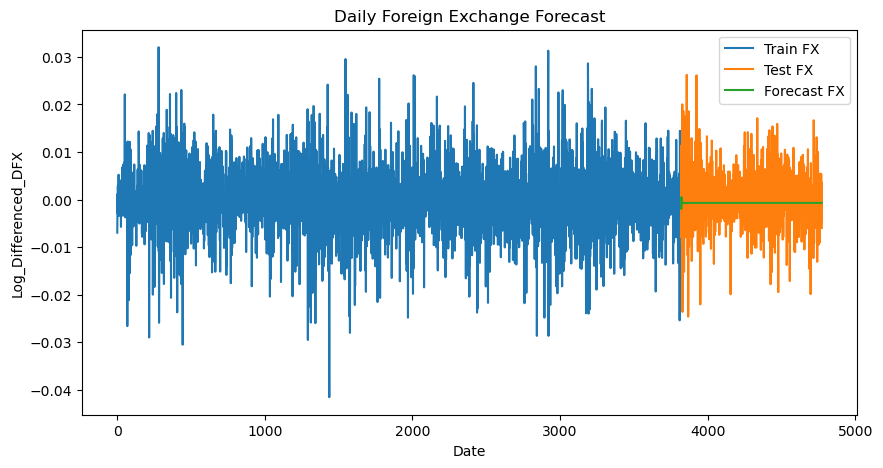

In [23]:
# Step 9: Plot Forecast
plt.figure(figsize=(10, 5))
plt.plot(train['Log_Differenced_DFX'], label='Train FX')
plt.plot(test['Log_Differenced_DFX'], label='Test FX')
plt.plot(test['Forecast'], label='Forecast FX')
plt.title('Daily Foreign Exchange Forecast')
plt.xlabel('Date')
plt.ylabel('Log_Differenced_DFX')
plt.legend()
plt.show()